---

# **About the Project**

---

## **Introduction**

The NYC Taxi Trip Dataset contains detailed trip records from taxis in New York City, dating back to 2009. This dataset, provided by the NYC Taxi and Limousine Commission (TLC), captures billions of taxi rides, making it one of the largest publicly available datasets for urban transportation research.

---

## **Key Features of the Dataset**

Each row in the dataset represents a single taxi trip and contains the following key features:

- **PickupandDrop-off Timestamps**: The time when a trip starts and ends

- **Pickup and Drop-off Locations**: Latitude and longitude coordinates of where the trip begins and ends

- **Trip Distance**: The distance traveled during the trip (in miles)

- **FareAmount**: Total cost of the trip, including base fare, taxes, and surcharges

- **PaymentType**: The method of payment used (e.g., cash or card)

These features provide crucial insights into trip duration, travel patterns, pricing, and customer behavior.

---

## **Collection Process**

The dataset is collected by the NYC Taxi and Limousine Commission (TLC) from yellow and green taxis operating in the city. Each taxi is equipped with a GPS-enabled meter that records key details of every trip, including pickup/drop-off locations, fare, and payment method. The data is collected in real-time and stored in the TLC's central database, then anonymized and made available to the public for analysis.

---

## **Structure**

We will be focusing on Yellow Taxi trips. The dataset is already available in Parquet format.

---

## **Data Coverage**

- Start Year: 2009
- End Year: Present (the dataset continues to be updated monthly)
- Frequency of Updates: Monthly

***Note: For this analysis, we will focus on data for 6 months only - Jul-Dec 2012***

---

# **Setup**

1. **Mounting Google Drive**: This allowed for efficient access to stored data files, avoiding the need to upload files manually each time.

2. **Initializing Custom Spark Session**: A Spark session was initialized with a high memory allocation (`spark.driver.memory` set to `32g`). This configuration provided sufficient memory for Spark to handle large datasets without running into memory issues, ensuring smooth execution of data processing tasks.

1. **Data Paths and Directories**: This systematic directory structure ensured data files were easily accessible at each stage of processing.



## Mounting Google Drive


In [1]:
# Mounting the Google Drive to access the data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
!pip install pyspark

In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import os
import seaborn as sns

In [4]:
from pyspark.sql.functions import col, hour, dayofmonth, dayofweek, weekofyear, year, month, unix_timestamp, count, when, lit, sum, udf
from pyspark.sql.types import DoubleType

In [5]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, ClusteringEvaluator
from pyspark.ml import Pipeline

In [6]:
# Initializing a Spark session
spark = SparkSession.builder.appName("NYC_Taxi_Trip_Insights").config("spark.driver.memory", "32g").getOrCreate()

## Data Paths and Directories


In [7]:
# Forlder Directory Path
data_dir = '/content/drive/My Drive/Big_Data_Project_3/'

In [8]:
file_paths = [data_dir + "parquet_files/yellow_tripdata_2012-07.parquet",
              data_dir + "parquet_files/yellow_tripdata_2012-08.parquet",
              data_dir + "parquet_files/yellow_tripdata_2012-09.parquet",
              data_dir + "parquet_files/yellow_tripdata_2012-10.parquet",
              data_dir + "parquet_files/yellow_tripdata_2012-11.parquet",
              data_dir + "parquet_files/yellow_tripdata_2012-12.parquet"]

In [9]:
# Directory to orginal files
original_dir = data_dir + "parquet_files/"

In [10]:
# Directory to save cleaned parquet files
cleaned_dir = data_dir + "cleaned_parquet_files/"
os.makedirs(cleaned_dir, exist_ok=True)

In [11]:
# Directory to save cleaned parquet files with time-based features
time_features_dir = data_dir + "time_based_features_parquet_files/"
os.makedirs(time_features_dir, exist_ok=True)

In [12]:
# Directory to save aggregated demand and congestion data
demand_congestion_dir = data_dir + "demand_congestion_analysis/"
os.makedirs(demand_congestion_dir, exist_ok=True)

In [13]:
# Directory to save sampled data
sampled_data_dir = data_dir + "sampled_monthly_data/"
os.makedirs(sampled_data_dir, exist_ok=True)

In [14]:
zone_lookup_path = f"{data_dir}taxi_zone_lookup_data/taxi_zone_lookup.csv"

---

# **Preprocessing**

1. Data Loading
2. Data Cleaning
3. Time based and Derived Features Calculation
4. Demand and Congestion Data Calculation
5. Data Sampling


## Data Loading

Each month's data was loaded as a separate Spark DataFrame to facilitate month-wise processing and avoid overwhelming memory by loading all data simultaneously. This setup allowed for efficient processing while maintaining flexibility for month-by-month analysis.

In [ ]:
# Loading each Parquet file as a Spark DataFrame
dfs = [spark.read.parquet(file) for file in file_paths]

# Checking the schema to understand the structure the data
dfs[0].printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: integer (nullable = true)
 |-- airport_fee: integer (nullable = true)



## Data Cleaning

   - **Dropping Unnecessary Columns**: Columns that didn't contribute directly to the analysis (e.g., `congestion_surcharge`, `airport_fee`) were removed to reduce data complexity and processing time.

   - **Handling Null Values**: Rows with null values in crucial columns (like `store_and_fwd_flag`) were dropped to ensure data integrity. Null value counts were checked to identify the scope of missing data, and duplicate rows were removed to avoid data redundancy.
   
   - **Saving Cleaned Data**: Each cleaned file was saved as a new Parquet file. Saving the cleaned data separately ensured that future steps could work with pre-processed data, making the workflow more efficient.

In [ ]:
# Step 1: Data Cleaning
for month_val in range(7, 13):  # From July (7) to December (12)
    original_file_path = f"{original_dir}yellow_tripdata_2012-{month_val:02d}.parquet"
    cleaned_file_path = f"{cleaned_dir}yellow_tripdata_2012-{month_val:02d}_cleaned.parquet"

    # Checking if the cleaned file already exists
    if os.path.exists(cleaned_file_path):
        print(f"Cleaned file for month {month_val} already exists. Skipping processing.")
        continue

    print(f"\nProcessing DataFrame for month {month_val}")

    # Loading the original data file
    taxi_data = spark.read.parquet(original_file_path)

    # Dropping unnecessary columns and rows with null values in 'store_and_fwd_flag'
    taxi_data = taxi_data.drop("congestion_surcharge", "airport_fee")
    taxi_data = taxi_data.filter(taxi_data.store_and_fwd_flag.isNotNull())

    # Dropping duplicate rows
    taxi_data = taxi_data.dropDuplicates()

    # Saving the cleaned data
    taxi_data.write.parquet(cleaned_file_path, mode="overwrite")
    print(f"Saved cleaned data for month {month_val} to {cleaned_file_path}")


Cleaned file for month 7 already exists. Skipping processing.
Cleaned file for month 8 already exists. Skipping processing.
Cleaned file for month 9 already exists. Skipping processing.
Cleaned file for month 10 already exists. Skipping processing.
Cleaned file for month 11 already exists. Skipping processing.
Cleaned file for month 12 already exists. Skipping processing.


## Time Based and Derived Features Calculation

   - **Enhanced Time-Based Features**: Added features like pickup and dropoff hour, day, weekday, and week of the year. These features allowed for temporal analyses, such as rush hour traffic patterns, which were crucial for demand and congestion modeling.

   - **Derived Metrics**:
      - **Rush Hour Indicator**: Created a binary indicator for rush hours (7-9 AM and 4-6 PM) to analyze how demand and congestion vary during peak times.

      - **Fare per Mile**: Calculated to understand the fare dynamics concerning distance.

      - **High/Low Fare Indicator**: A binary feature indicating if the fare exceeds a certain threshold, enabling classification-based modeling.

      - **Tip-to-Fare Ratio**: Calculated to observe tipping trends relative to fare. This metric provided insights into tipping behavior, which could vary based on trip characteristics.

In [ ]:
# Step 2: Adding Enhanced Time-Based and Derived Features
for month_val in range(7, 13):
    cleaned_file_path = f"{cleaned_dir}yellow_tripdata_2012-{month_val:02d}_cleaned.parquet"
    time_features_file_path = f"{time_features_dir}yellow_tripdata_2012-{month_val:02d}_time_features.parquet"

    # Checking if time-featured file exists
    if os.path.exists(time_features_file_path):
        print(f"File with time-based features for month {month_val} already exists. Skipping processing.")
        continue

    print(f"\nProcessing time-based features for month {month_val}")

    # Loading cleaned data
    taxi_data = spark.read.parquet(cleaned_file_path)

    # Adding time-based features, trip duration, and derived metrics
    taxi_data = taxi_data.withColumn("pickup_hour", hour(col("tpep_pickup_datetime"))) \
                         .withColumn("pickup_day", dayofmonth(col("tpep_pickup_datetime"))) \
                         .withColumn("pickup_weekday", dayofweek(col("tpep_pickup_datetime"))) \
                         .withColumn("pickup_week", weekofyear(col("tpep_pickup_datetime"))) \
                         .withColumn("pickup_month", month(col("tpep_pickup_datetime"))) \
                         .withColumn("dropoff_hour", hour(col("tpep_dropoff_datetime"))) \
                         .withColumn("dropoff_day", dayofmonth(col("tpep_dropoff_datetime"))) \
                         .withColumn("dropoff_weekday", dayofweek(col("tpep_dropoff_datetime"))) \
                         .withColumn("dropoff_week", weekofyear(col("tpep_dropoff_datetime"))) \
                         .withColumn("trip_duration", (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60)

    # Adding additional derived features for analysis
    # Rush hour indicator
    taxi_data = taxi_data.withColumn("rush_hour",
                                     when((col("pickup_hour").between(7, 9)) | (col("pickup_hour").between(16, 18)), 1).otherwise(0))

    # Fare per mile (avoiding division by zero)
    taxi_data = taxi_data.withColumn("fare_per_mile",
                                     when(col("trip_distance") > 0, col("fare_amount") / col("trip_distance")).otherwise(lit(None)))

    # High/Low fare indicator (using a pre-defined threshold)
    fare_threshold = 12  # threshold for the analysis
    taxi_data = taxi_data.withColumn("high_fare", when(col("fare_amount") >= fare_threshold, 1).otherwise(0))

    # Tip-to-fare ratio (avoiding division by zero)
    taxi_data = taxi_data.withColumn("tip_to_fare_ratio",
                                     when(col("fare_amount") > 0, col("tip_amount") / col("fare_amount")).otherwise(lit(None)))

    # Saving data with enhanced features
    taxi_data.write.parquet(time_features_file_path, mode="overwrite")
    print(f"Saved time-based and derived features data for month {month_val} to {time_features_file_path}")


File with time-based features for month 7 already exists. Skipping processing.
File with time-based features for month 8 already exists. Skipping processing.
File with time-based features for month 9 already exists. Skipping processing.
File with time-based features for month 10 already exists. Skipping processing.
File with time-based features for month 11 already exists. Skipping processing.
File with time-based features for month 12 already exists. Skipping processing.


## Demand and Congestion Data Calculation

   - **Demand Hotspots**: Aggregated data by pickup location and time (hour and weekday) to identify demand hotspots. Grouping by location and time enabled time-based demand analysis, revealing high-demand areas during different times of the day.

   - **Congestion Hotspots**: Similar to demand analysis but focused on dropoff locations to identify congestion hotspots, highlighting areas with high dropoff counts.
   
   These insights helped identify congested areas across different hours and weekdays, valuable for optimizing taxi availability.

In [ ]:
# Step 3: Demand and Congestion Data
for month_val in range(7, 13):
    time_features_file_path = f"{time_features_dir}yellow_tripdata_2012-{month_val:02d}_time_features.parquet"
    demand_file_path = f"{demand_congestion_dir}demand_hotspots_2012-{month_val:02d}.parquet"
    congestion_file_path = f"{demand_congestion_dir}congestion_hotspots_2012-{month_val:02d}.parquet"

    # Checking if demand and congestion files exist
    if os.path.exists(demand_file_path) and os.path.exists(congestion_file_path):
        print(f"Demand and congestion data for month {month_val} already exists. Skipping processing.")
        continue

    # Loading data with time-based features
    taxi_data = spark.read.parquet(time_features_file_path)

    # Calculating demand hotspots by pickup location and time
    demand_data = taxi_data.groupBy("PULocationID", "pickup_hour", "pickup_weekday") \
                           .agg(count("*").alias("trip_count")) \
                           .orderBy("PULocationID", "pickup_hour", "pickup_weekday")
    demand_data.write.parquet(demand_file_path, mode="overwrite")
    print(f"Saved demand hotspot data for month {month_val} to {demand_file_path}")

    # Calculating congestion hotspots by drop-off location and time
    congestion_data = taxi_data.groupBy("DOLocationID", "dropoff_hour", "dropoff_weekday") \
                               .agg(count("*").alias("trip_count")) \
                               .orderBy("DOLocationID", "dropoff_hour", "dropoff_weekday")
    congestion_data.write.parquet(congestion_file_path, mode="overwrite")
    print(f"Saved congestion hotspot data for month {month_val} to {congestion_file_path}")

Demand and congestion data for month 7 already exists. Skipping processing.
Demand and congestion data for month 8 already exists. Skipping processing.
Demand and congestion data for month 9 already exists. Skipping processing.
Demand and congestion data for month 10 already exists. Skipping processing.
Demand and congestion data for month 11 already exists. Skipping processing.
Demand and congestion data for month 12 already exists. Skipping processing.


## Data Sampling
 A 30% random sample of the data was created to expedite model training and analysis, maintaining a balance between data representativeness and computational efficiency.
  

In [ ]:
# Step 4: Sampling Process
sample_fraction = 0.3  # 30% sample
for month_val in range(7, 13):
    time_features_file_path = f"{time_features_dir}yellow_tripdata_2012-{month_val:02d}_time_features.parquet"
    sampled_file_path = f"{sampled_data_dir}yellow_tripdata_2012-{month_val:02d}_sampled.parquet"

    # Checking if sampled file already exists
    if os.path.exists(sampled_file_path):
        print(f"Sampled file for month {month_val} already exists. Skipping processing.")
        continue

    print(f"\nSampling data for month {month_val}...")

    # Loading data with time-based features
    taxi_data = spark.read.parquet(time_features_file_path)

    # Sampling 30% of the data
    sampled_data = taxi_data.sample(withReplacement=False, fraction=sample_fraction, seed=42)

    # Saving sampled data
    sampled_data.write.parquet(sampled_file_path, mode="overwrite")
    print(f"Saved sampled data for month {month_val} to {sampled_file_path}")

Sampled file for month 7 already exists. Skipping processing.
Sampled file for month 8 already exists. Skipping processing.
Sampled file for month 9 already exists. Skipping processing.
Sampled file for month 10 already exists. Skipping processing.
Sampled file for month 11 already exists. Skipping processing.
Sampled file for month 12 already exists. Skipping processing.


In [ ]:
print("\nAll data processing steps completed.")


All data processing steps completed.


---

# **Analysis**

*** Note: All questions were attempted. ***

Order: Q1 > Q8 > Q2 > Q3 > Q4 > Q5 > Q6 > Q7

---

## **Question 1** - *Identify regions in the city with high demand for taxis. For instance, you can create a heatmap of NYC showing demand hotspots on a monthly basis*

   Aggregated trip counts by pickup location and month to identify regions with consistently high demand. The data was enriched with zone names for better interpretability.


   

### Loading Zone Lookup Table and Preparing for Join

In [ ]:
# Loading the lookup table with LocationID to Zone mapping
zone_lookup = spark.read.csv(zone_lookup_path, header=True, inferSchema=True)
zone_lookup = zone_lookup.withColumnRenamed("LocationID", "PULocationID")

In [ ]:
# Initializing variable to store combined data
demand_monthly_data = None


In [ ]:
# Aggregating trip counts by pickup location and month (July to December)
for month_val in range(7, 13):
    # Loading time-featured data for each month
    time_features_file_path = f"{time_features_dir}yellow_tripdata_2012-{month_val:02d}_time_features.parquet"
    taxi_data = spark.read.parquet(time_features_file_path)

    # Ensuring correct extraction of pickup_month
    taxi_data = taxi_data.withColumn("pickup_month", month(col("tpep_pickup_datetime")))

    # Aggregating demand by pickup location and month
    monthly_demand_data = taxi_data.groupBy("PULocationID", "pickup_month") \
                                   .agg(count("*").alias("monthly_trip_count"))

    # Combining monthly data
    demand_monthly_data = monthly_demand_data if demand_monthly_data is None else demand_monthly_data.union(monthly_demand_data)


In [ ]:
# Joining the demand data with zone lookup to get region names
demand_monthly_data_with_names = demand_monthly_data.join(zone_lookup, on="PULocationID", how="left")

In [ ]:
# Summarizing demand data by Zone and pickup month across all months
total_demand_monthly_data = demand_monthly_data_with_names.groupBy("PULocationID", "Zone", "pickup_month") \
                                                         .agg(sum("monthly_trip_count").alias("total_trip_count"))

In [ ]:
# Collecting the results into a DataFrame for analysis in Pandas
demand_monthly_df = total_demand_monthly_data.toPandas()

### Listing Top Regions with Highest Demand

In [ ]:
# Aggregating by Zone to get the total demand for each region
top_regions_df = demand_monthly_df.groupby(["PULocationID", "Zone"])["total_trip_count"].sum().reset_index()
top_regions_df = top_regions_df.sort_values(by="total_trip_count", ascending=False).head(10)  # Top 10 high-demand regions

print("Top 10 High-Demand Regions with PULocationID and Zone Name:")
print(top_regions_df)

Top 10 High-Demand Regions with PULocationID and Zone Name:
     PULocationID                          Zone  total_trip_count
236           237         Upper East Side South           1586220
160           161                Midtown Center           1491550
78             79                  East Village           1471504
229           230     Times Sq/Theatre District           1455772
47             48                  Clinton East           1440052
233           234                      Union Sq           1417806
161           162                  Midtown East           1416148
169           170                   Murray Hill           1407493
235           236         Upper East Side North           1375622
185           186  Penn Station/Madison Sq West           1359821


### Visualization

#### Creating a Heatmap for Demand Hotspots on a Weekly Basis

In [ ]:
# Pivoting the DataFrame to create a matrix with 'Zone' as rows and 'pickup_month' as columns
heatmap_data = demand_monthly_df.pivot_table(index="Zone", columns="pickup_month", values="total_trip_count", fill_value=0)

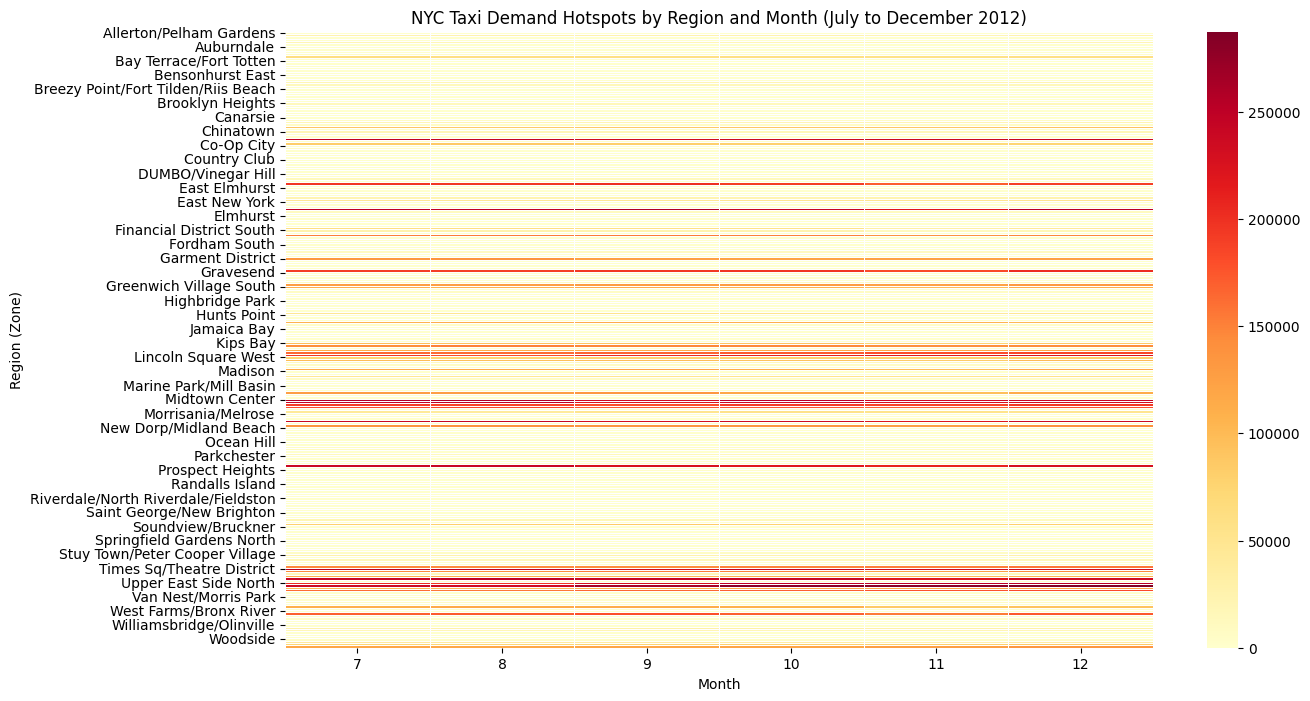

In [ ]:
# Plotting the heatmap with region names
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.5)
plt.title("NYC Taxi Demand Hotspots by Region and Month (July to December 2012)")
plt.xlabel("Month")
plt.ylabel("Region (Zone)")
plt.show()

### Interpretation of Result

1. **Heatmap of NYC Taxi Demand Hotspots by Region and Month**:
   - The intensity of demand varies by region, with certain zones consistently displaying high demand each month, evident through darker shades on the heatmap.

   - Regions like **Midtown Center**, **Upper East Side South**, and **Times Square/Theatre District** are consistently high-demand areas, which aligns with their commercial and tourist importance.

2. **Top 10 High-Demand Regions**:
   - **Upper East Side South** leads the demand, followed closely by **Midtown Center** and **East Village**.

   - **Times Square/Theatre District**, **Union Square**, and **Penn Station/Madison Square West** are also among the highest-demand regions, reflecting their roles as transportation and tourism hubs.

   - Residential neighborhoods like **Upper East Side** and business areas like **Murray Hill** also show significant demand, suggesting they are popular pickup locations for residents and commuters.



---

## **Question 8** - *Identify and predict traffic congestion hotspots based on trip patterns and times*

   - **Congestion Threshold Calculation**: Fixed a congestion threshold at 90th percentile of trip counts, classified zones with counts above this threshold as congested. This approach standardized congestion classification.

   - **Predictive Modeling**:
      - **Feature Engineering**: Extracted features like dropoff hour, weekday, and DOLocationID for predictive modeling.

      - **Random Forest Classifier**: Trained a Random Forest Classifier to predict congestion status based on early trip data, using a robust ensemble method suited for binary classification.

   - **Optimal Threshold Calculation**: Used Youden's J Statistic to determine an optimal threshold for high congestion, applying it to improve classification performance and confirmation.

  

### Loading Congestion Data

In [15]:
congestion_data = None
for month_val in range(7, 13):
    congestion_file_path = f"{demand_congestion_dir}congestion_hotspots_2012-{month_val:02d}.parquet"
    monthly_congestion_data = spark.read.parquet(congestion_file_path)
    congestion_data = monthly_congestion_data if congestion_data is None else congestion_data.union(monthly_congestion_data)

### Defining Congestion Threshold

In [16]:
congestion_threshold = congestion_data.approxQuantile("trip_count", [0.9], 0.05)[0]
congestion_data = congestion_data.withColumn("is_congested", (col("trip_count") >= congestion_threshold).cast("int"))

### Mapping Zone Lookup Data

In [17]:
# Loading Zone Lookup Table to Map DOLocationID to Zone Names
zone_lookup = spark.read.csv(zone_lookup_path, header=True, inferSchema=True)
zone_lookup = zone_lookup.withColumnRenamed("LocationID", "DOLocationID")  # Rename to match DOLocationID in congestion data

# Ensuring the join column name matches
zone_lookup = zone_lookup.withColumnRenamed("PULocationID", "DOLocationID")

# Mapping DOLocationID to Zone Names for Better Interpretation
congestion_data = congestion_data.join(zone_lookup, on="DOLocationID", how="left")


### Predictive Modeling

In [18]:
# Feature Engineering and Predictive Modeling
feature_cols = ["dropoff_hour", "dropoff_weekday", "DOLocationID"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
congestion_data = assembler.transform(congestion_data)

### Data Splitting

In [19]:
# Splitting Data into Training and Test Sets
train_data, test_data = congestion_data.randomSplit([0.8, 0.2], seed=42)


### Model Training

In [20]:
# Training the Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="is_congested", numTrees=50, maxDepth=10, seed=42)
rf_model = rf.fit(train_data)

### Model Testing

In [21]:
# Making Predictions and Evaluate the Model
predictions = rf_model.transform(test_data)

### Model Evaluation



In [22]:
# Model Evaluation - ROC and AUC Calculation
evaluator = BinaryClassificationEvaluator(labelCol="is_congested", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"Model AUC for congestion prediction = {auc:.3f}")

Model AUC for congestion prediction = 0.828


In [23]:
tp = predictions.filter((col("prediction") == 1) & (col("is_congested") == 1)).count()
tn = predictions.filter((col("prediction") == 0) & (col("is_congested") == 0)).count()
fp = predictions.filter((col("prediction") == 1) & (col("is_congested") == 0)).count()
fn = predictions.filter((col("prediction") == 0) & (col("is_congested") == 1)).count()

In [24]:
# Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy on test data = {accuracy:.3f}")

# Precision
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
print(f"Precision on test data = {precision:.3f}")

# Recall
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"Recall on test data = {recall:.3f}")

Accuracy on test data = 0.878
Precision on test data = 0.646
Recall on test data = 0.310


### Optimal Threshold Calculation for Confirmation


In [25]:
# Defining UDF to extract the probability of class 1 (congested)
def extract_congested_probability(probability):
    return float(probability.values[1])  # Probability for class 1
extract_congested_probability_udf = udf(extract_congested_probability, DoubleType())


In [26]:
# Applying UDF to add a column for congestion probability
predictions = predictions.withColumn("congested_probability", extract_congested_probability_udf(col("probability")))

In [27]:
# Collecting the true labels and predicted probabilities
preds_and_labels = predictions.select("congested_probability", "is_congested").collect()
probs = np.array([row["congested_probability"] for row in preds_and_labels])
labels = np.array([row["is_congested"] for row in preds_and_labels])

In [28]:
# Calculating TPR, FPR, and thresholds for ROC curve
fpr, tpr, thresholds = [], [], []
sorted_indices = np.argsort(probs)[::-1]
probs, labels = probs[sorted_indices], labels[sorted_indices]


In [29]:
# Calculating TPR and FPR for each threshold
for threshold in np.unique(probs):
    tp = np.sum((probs >= threshold) & (labels == 1))
    fp = np.sum((probs >= threshold) & (labels == 0))
    fn = np.sum((probs < threshold) & (labels == 1))
    tn = np.sum((probs < threshold) & (labels == 0))
    tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
    thresholds.append(threshold)

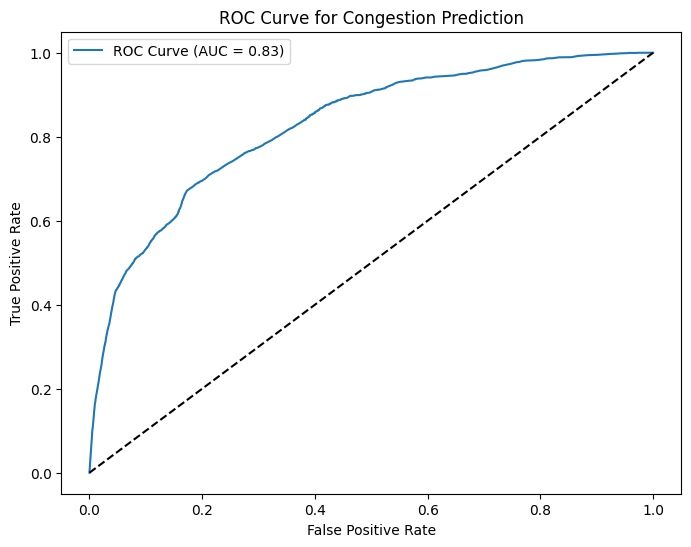

In [30]:
# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Congestion Prediction')
plt.legend(loc='best')
plt.show()

In [31]:
# Finding Optimal Threshold Using Youden's J Statistic
j_scores = np.array(tpr) - np.array(fpr)
optimal_index = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_index]
print(f"Optimal threshold based on Youden's J statistic: {optimal_threshold:.3f}")

Optimal threshold based on Youden's J statistic: 0.146


### Applying Optimal Threshold

In [32]:
# Applying Optimal Threshold to Make Predictions
predictions = predictions.withColumn("optimal_congestion_pred",
                                     (col("congested_probability") >= optimal_threshold).cast("int"))

### Re-evaluation of the Model

In [33]:
# Evaluating Model Using Optimal Threshold
evaluator = BinaryClassificationEvaluator(labelCol="is_congested", rawPredictionCol="congested_probability", metricName="areaUnderROC")
optimal_auc = evaluator.evaluate(predictions)
print(f"Model AUC using the optimal threshold = {optimal_auc:.3f}")

Model AUC using the optimal threshold = 0.828


### Top Congestion Hotspots

In [34]:
congestion_predictions = predictions.filter(predictions["is_congested"] == 1) \
                                    .groupBy("DOLocationID", "Zone") \
                                    .agg(sum("trip_count").alias("total_trip_count")) \
                                    .orderBy(col("total_trip_count").desc())
print("Top 10 Predicted Congested Regions:")
congestion_predictions.show(10)

Top 10 Predicted Congested Regions:
+------------+--------------------+----------------+
|DOLocationID|                Zone|total_trip_count|
+------------+--------------------+----------------+
|         161|      Midtown Center|          384549|
|         237|Upper East Side S...|          329238|
|         230|Times Sq/Theatre ...|          284871|
|         236|Upper East Side N...|          255235|
|         162|        Midtown East|          244851|
|         234|            Union Sq|          236580|
|         186|Penn Station/Madi...|          232141|
|          48|        Clinton East|          230280|
|         170|         Murray Hill|          229520|
|          79|        East Village|          224930|
+------------+--------------------+----------------+
only showing top 10 rows



### Visualization

#### Heatmap of Congestion Hotspots

In [35]:
congestion_heatmap_df = congestion_data.groupBy("Zone", "dropoff_hour") \
                                       .agg(sum("trip_count").alias("total_trip_count")) \
                                       .toPandas().pivot(index="Zone", columns="dropoff_hour", values="total_trip_count").fillna(0)

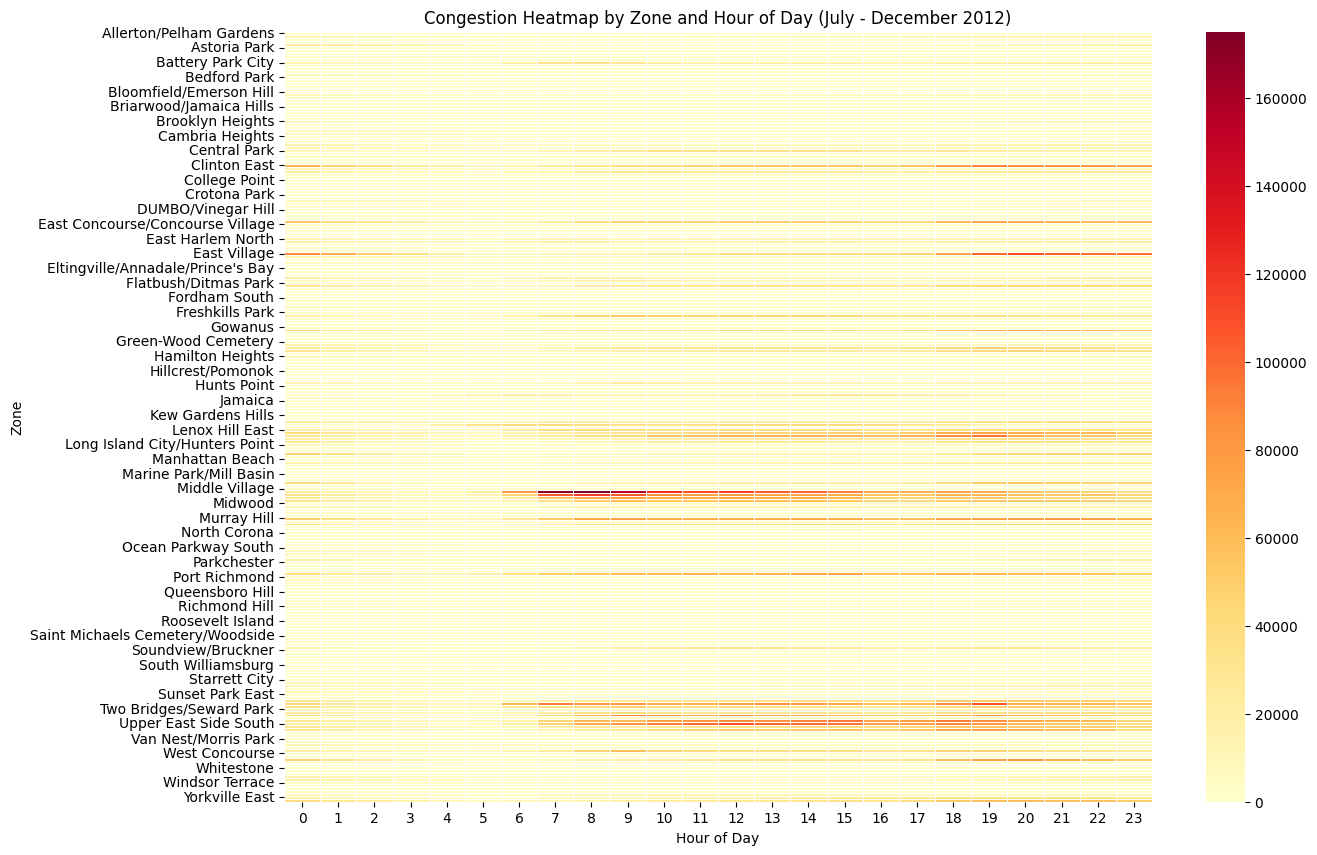

In [36]:
plt.figure(figsize=(14, 10))
sns.heatmap(congestion_heatmap_df, cmap="YlOrRd", linewidths=0.5)
plt.title("Congestion Heatmap by Zone and Hour of Day (July - December 2012)")
plt.xlabel("Hour of Day")
plt.ylabel("Zone")
plt.show()

### Interpretation of Result

1. **Congestion Heatmap by Zone and Hour of Day**:
   - The heatmap visually represents traffic congestion patterns across different zones in NYC throughout the day.

   - The intensity of congestion varies significantly between zones, with certain areas exhibiting high congestion levels at specific hours. For instance, **Midtown Center** and **Upper East Side South** show concentrated congestion during certain hours.

   - The highest congestion appears to occur early in the morning and around evening, suggesting rush-hour peaks where demand for taxis is high in certain areas.

2. **Top 10 Predicted Congested Regions**:

   - **Midtown Center**, **Upper East Side South**, and **Times Square/Theatre District** emerge as the highest-congestion zones, likely due to their popularity as business, shopping, and entertainment hubs.

   - Other notable areas include **Union Square**, **Penn Station/Madison Sq West**, and **East Village**, which are also prominent for their high foot traffic and transportation hubs.


---

## **Question 2** - *Predict the duration of a taxi trip based on trip start time and location (pick up and drop off)*

   - **Feature Engineering**: Selected features like trip distance, PULocationID, DOLocationID, and pickup time variables. These features provided a basis for estimating trip duration based on spatial and temporal factors.

   - **Random Forest Regressor**: Trained a Random Forest Regressor due to data not being linear and it's high interpretability and accuracy in regression tasks. This model predicted trip duration based on selected features.

   - **Evaluation and Visualization**: Evaluated using RMSE and MAE, and created visualizations such as the Actual vs. Predicted plot and more.

  

### Data Loading

In [ ]:
# Columns needed for trip duration prediction
required_columns = [
    "trip_distance", "PULocationID", "DOLocationID", "pickup_hour", "pickup_day",
    "pickup_weekday", "trip_duration"
]

In [ ]:
# Loading each sampled monthly file, selecting relevant columns, and combining into a single DataFrame
sampled_data = None
for month_val in range(7, 13):  # From July to December
    sampled_file_path = f"{sampled_data_dir}yellow_tripdata_2012-{month_val:02d}_sampled.parquet"
    month_data = spark.read.parquet(sampled_file_path).select(*required_columns)
    sampled_data = month_data if sampled_data is None else sampled_data.union(month_data)

### Data Filtering

In [ ]:
# Filtering out rows with missing or zero trip distance for cleaner training
sampled_data = sampled_data.filter((col("trip_distance") > 0) & (col("trip_duration").isNotNull()))

### Feature Assembling

In [ ]:
# Assembling features into a single vector column for modeling
feature_columns = ["trip_distance", "PULocationID", "DOLocationID", "pickup_hour", "pickup_day", "pickup_weekday"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
sampled_data = assembler.transform(sampled_data)

In [ ]:
# Adding a rush hour indicator feature
sampled_data = sampled_data.withColumn("rush_hour",
                                       when((col("pickup_hour").between(7, 9)) | (col("pickup_hour").between(16, 18)), 1).otherwise(0))

In [ ]:
# Assembling features into a single vector column for modeling
enhanced_feature_columns = ["trip_distance", "PULocationID", "DOLocationID", "pickup_hour", "pickup_day", "pickup_weekday", "rush_hour"]
assembler = VectorAssembler(inputCols=enhanced_feature_columns, outputCol="features")
sampled_data = assembler.transform(sampled_data)


### Data Splitting

In [ ]:
# Splitting enhanced data into training and test sets (80% training, 20% test)
train_data, test_data = enhanced_data.randomSplit([0.8, 0.2], seed=42)


### Model Training and Testing

In [ ]:
# Initializing and train the Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="trip_duration", numTrees=50, maxDepth=10, seed=42)
rf_model = rf.fit(train_data)

# Making predictions on the test set
predictions = rf_model.transform(test_data)

### Model Evaluations

In [ ]:
# Initializing evaluator for RMSE and MAE
evaluator_rmse = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data with Random Forest = {rmse}")

evaluator_mae = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data with Random Forest = {mae}")


Root Mean Squared Error (RMSE) on test data with Random Forest = 21.24123831928371
Mean Absolute Error (MAE) on test data with Random Forest = 3.2196163720965454


### Visualisations

In [ ]:
# Convert predictions to pandas DataFrame for easier plotting
predictions_df = predictions.select("trip_duration", "prediction").toPandas()

#### Feature Importance

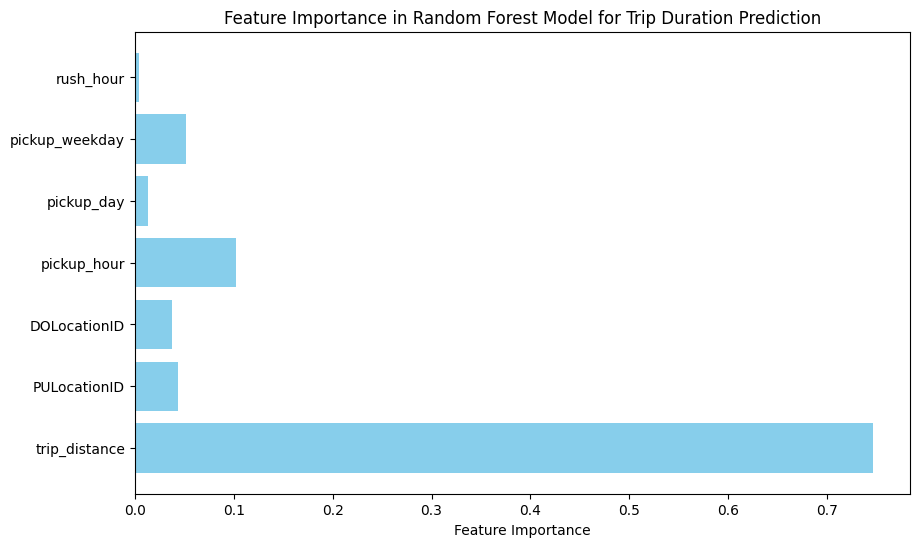

In [ ]:
# Feature Importance Plot
feature_importances = rf_model.featureImportances.toArray()
plt.figure(figsize=(10, 6))
plt.barh(enhanced_feature_columns, feature_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest Model for Trip Duration Prediction")
plt.show()

#### Actual vs. Predicted Trip Duration

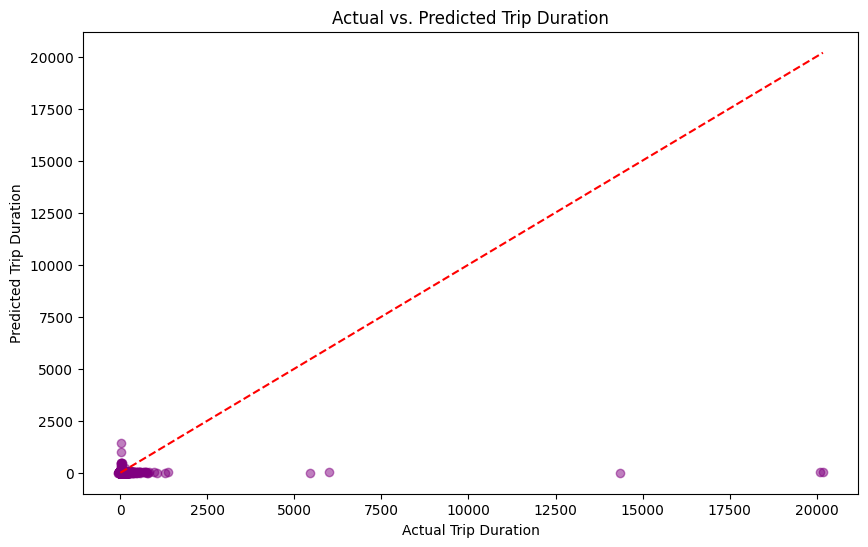

In [ ]:
# Actual vs. Predicted Trip Duration Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['trip_duration'], predictions_df['prediction'], alpha=0.5, color='purple')
plt.plot([0, predictions_df['trip_duration'].max()], [0, predictions_df['trip_duration'].max()], 'r--')
plt.xlabel("Actual Trip Duration")
plt.ylabel("Predicted Trip Duration")
plt.title("Actual vs. Predicted Trip Duration")
plt.show()

#### Residuals

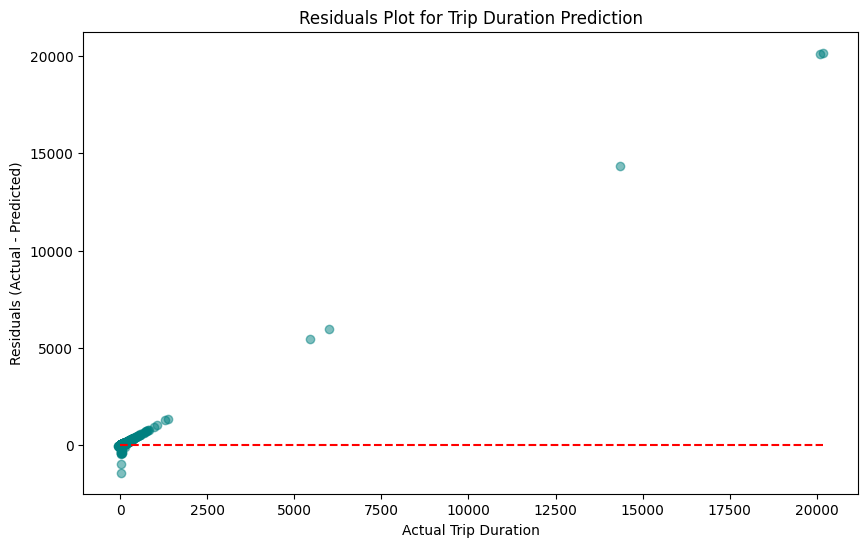

In [ ]:
# Residuals Plot
predictions_df['residuals'] = predictions_df['trip_duration'] - predictions_df['prediction']
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['trip_duration'], predictions_df['residuals'], alpha=0.5, color='teal')
plt.hlines(0, xmin=0, xmax=predictions_df['trip_duration'].max(), colors='r', linestyles='dashed')
plt.xlabel("Actual Trip Duration")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Plot for Trip Duration Prediction")
plt.show()

### Interpretation of Results

1. **Actual vs. Predicted Trip Duration Plot**:
   - The plot shows a comparison between the actual trip durations and the model's predictions. The closer the points are to the diagonal red line, the better the predictions match the actual values.

   - For shorter trip durations (where most points are clustered), predictions appear to follow the actual durations closely, indicating that the model performs reasonably well for these cases.

   - However, there are a few extreme outliers with very high trip durations (over 5000 seconds), where the predictions do not match well with the actual values. This could indicate that the model struggles with accurately predicting trips with unusually long durations.

2. **Residuals Plot**:
   - This plot displays the residuals (differences between actual and predicted trip durations) for each data point. Ideally, residuals should be close to zero for accurate predictions.

   - For most trips, residuals are small, indicating that the model has good accuracy for typical trip durations.

   - The significant residuals for the few high-duration trips suggest that the model fails to account for certain factors that could influence longer trips.


---

## **Question 3** - *Segment passengers on the basis of trip characteristics, such as trip distance, fare, time of day, and payment method*

   - **Clustering with KMeans**: Applied KMeans clustering with standardized features like trip distance, fare amount, and pickup hour. This segmentation identified common passenger trip patterns.

   - **Optimal K Selection**: Used the Silhouette score to determine the optimal number of clusters.



### Data Loading

In [ ]:
# Columns needed for segmentation
segmentation_columns = ["trip_distance", "fare_amount", "pickup_hour", "payment_type"]

In [ ]:
# Loading each sampled monthly file, select relevant columns, and combine into a single DataFrame
sampled_data = None
for month_val in range(7, 13):  # From July to December
    sampled_file_path = f"{sampled_data_dir}yellow_tripdata_2012-{month_val:02d}_sampled.parquet"
    month_data = spark.read.parquet(sampled_file_path).select(*segmentation_columns)
    sampled_data = month_data if sampled_data is None else sampled_data.union(month_data)


### Sample Data Visualisation

In [ ]:
# Taking a small sample of the data to visualize (e.g., 5% of the data)
sample_fraction = 0.05  # 5% of the data for visualization
visualization_sample = sampled_data.sample(withReplacement=False, fraction=sample_fraction, seed=42)
visualization_df = visualization_sample.toPandas()

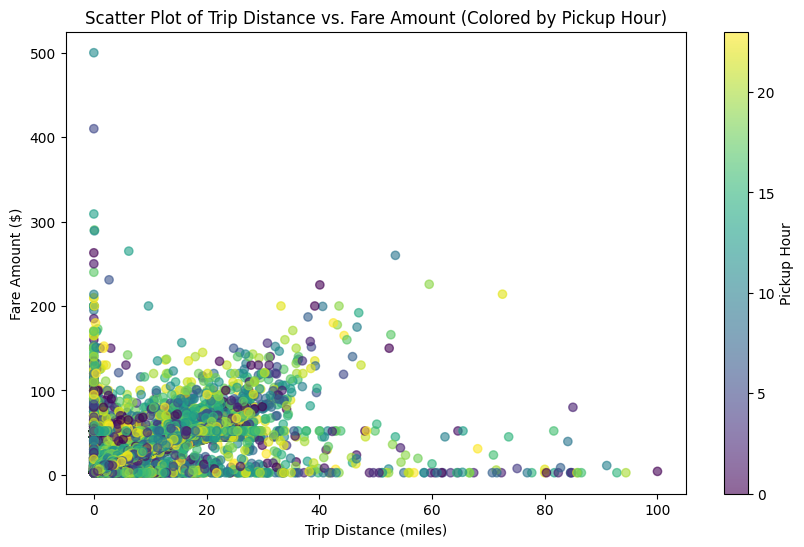

In [ ]:
# Plotting the sample data to observe potential clusters or outliers (trip distance vs. fare amount, colored by pickup hour)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(visualization_df["trip_distance"], visualization_df["fare_amount"],
                      alpha=0.6, c=visualization_df["pickup_hour"], cmap="viridis")
plt.colorbar(scatter, label="Pickup Hour")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.title("Scatter Plot of Trip Distance vs. Fare Amount (Colored by Pickup Hour)")
plt.show()

### Outlier Filtering

In [ ]:
# thresholding based on the data distribution
percentile_threshold = 0.98
trip_distance_threshold = sampled_data.approxQuantile("trip_distance", [percentile_threshold], 0.05)[0]
fare_amount_threshold = sampled_data.approxQuantile("fare_amount", [percentile_threshold], 0.05)[0]
sampled_data_filtered = sampled_data.filter((col("trip_distance") <= trip_distance_threshold) &
                                            (col("fare_amount") <= fare_amount_threshold))

### Feature Standardization

In [ ]:
# Standardizing Features for K-Means
assembler = VectorAssembler(inputCols=segmentation_columns, outputCol="features")
data_with_features = assembler.transform(sampled_data_filtered)

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(data_with_features)
data_scaled = scaler_model.transform(data_with_features)

### Finding Optimal K Value

In [ ]:
cost = []
K_range = range(2, 8)  # Trying K values from 2 to 7

In [ ]:
for k in K_range:
    kmeans = KMeans(featuresCol="scaled_features", k=k, initMode="k-means||", seed=42)
    model = kmeans.fit(data_scaled)
    predictions = model.transform(data_scaled)
    evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="prediction", metricName="silhouette")
    silhouette_score = evaluator.evaluate(predictions)
    cost.append(silhouette_score)

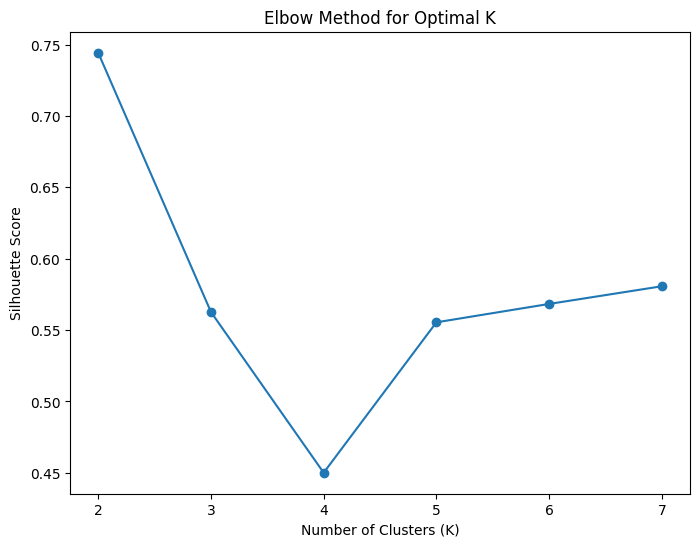

In [ ]:
# Plotting Elbow curve to determine optimal K
plt.figure(figsize=(8, 6))
plt.plot(K_range, cost, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Elbow Method for Optimal K")
plt.show()

### Model Training

Considering the structure in the scatter plot, K = 5 would be a balanced choice. It provides a better-defined clustering structure and a manageable number of clusters for interpretation and analysis.

In [ ]:
# Training K-Means Model with Optimal K
optimal_k = 5
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

Optimal number of clusters based on silhouette score: 5


In [ ]:
kmeans_optimal = KMeans(featuresCol="scaled_features", k=optimal_k, initMode="k-means||", seed=42)
kmeans_model = kmeans_optimal.fit(data_scaled)
final_predictions = kmeans_model.transform(data_scaled)

### Visualization

In [ ]:
# Visualizing the Clusters
plot_data = final_predictions.select("trip_distance", "fare_amount", "pickup_hour", "prediction").toPandas()

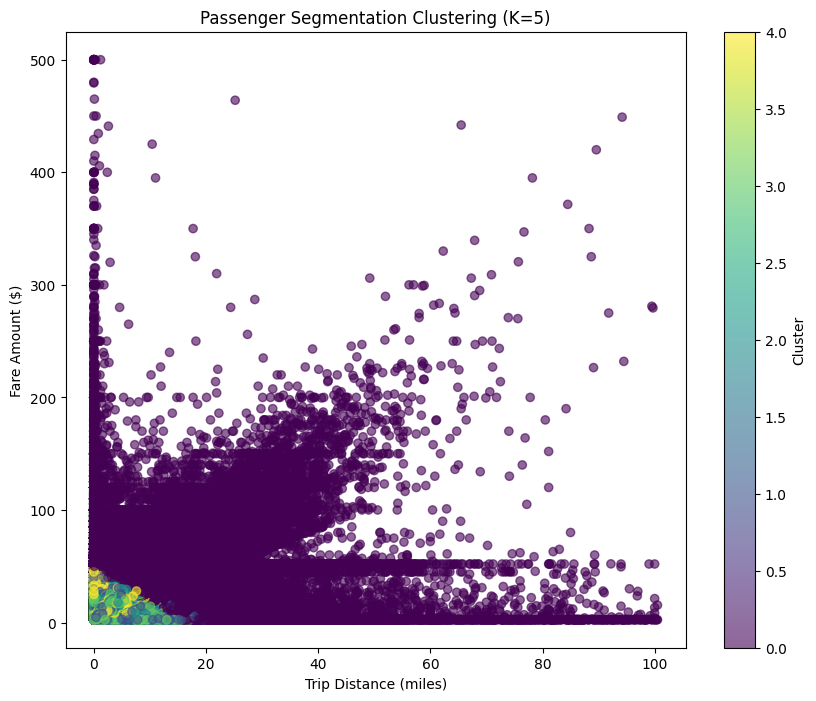

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(plot_data["trip_distance"], plot_data["fare_amount"], c=plot_data["prediction"], cmap="viridis", alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.title(f"Passenger Segmentation Clustering (K={optimal_k})")
plt.show()

### Interpretation Of Result

1. **Cluster Distribution**:
   - The plot reveals distinct clusters of passengers based on trip distance and fare amount.

   - Most of the data points (passenger trips) are concentrated in the lower left corner, indicating shorter trips with lower fares. These are likely the most common type of taxi trip in NYC, such as short intra-borough or local trips.

2. **Outliers and Long-Distance Trips**:
   - A few points are spread out towards the right (higher trip distances) and upper areas (higher fares), indicating trips that are longer in distance and/or have higher fares.

   - These outliers may represent trips to or from airports, inter-borough trips, or out-of-city trips that naturally have higher fares and longer distances.

3. **Segmentation Insights**:
   - **Cluster 0** (lower left corner) likely represents local, short, low-cost trips taken within boroughs or small neighborhoods.

   - **Clusters 1-4** (further spread out across the plot) might capture various types of trips with higher fares and distances. These could be influenced by factors like peak vs. off-peak hours, specific boroughs, or passenger payment methods.

4. **Fare vs. Distance Relationship**:
   - There is a rough linear relationship between trip distance and fare amount, with fare increasing as trip distance increases. However, there are many short-distance trips with varied fare amounts, likely due to minimum fare policies or differences in trip characteristics like traffic and route choices.


---

## **Question 4** - *Predict whether a passenger will pay by card or cash*

   - **Feature Selection**: Chose features strongly correlated with payment type, including trip distance, fare amount, total amount, and rush hour indicator.

   - **Binary Classification**: Trained a Random Forest Classifier to predict if the passenger would pay by card or cash.

   - **Optimal Threshold and Confusion Matrix**: Applied an optimal threshold based on Youden's J Statistic and visualized the confusion matrix to evaluate classification performance, highlighting the model's precision and recall for cash and card payments.


### Correlation Analysis

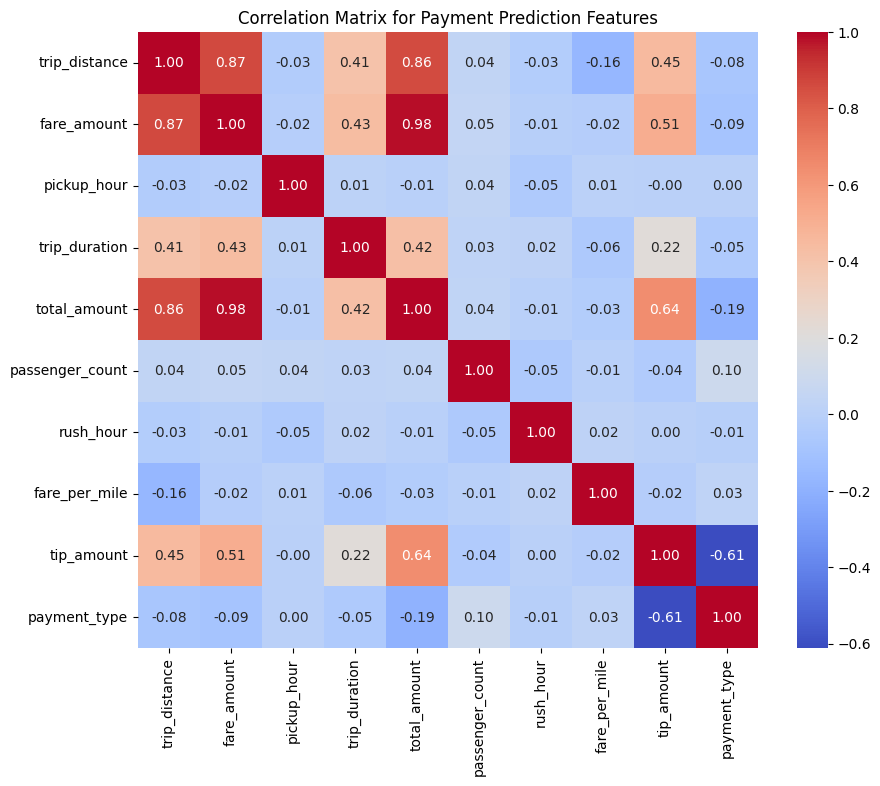

In [ ]:
# Converting Spark DataFrame to Pandas for correlation visualization
# Select only the required columns and ensure 'label' column is included for correlation with payment method
pandas_df = sampled_data.select("trip_distance", "fare_amount", "pickup_hour", "trip_duration", "total_amount", "passenger_count",
                                "rush_hour", "fare_per_mile", "tip_amount", "payment_type").toPandas()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pandas_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Payment Prediction Features")
plt.show()

### Feature Finalization

In [ ]:
# Columns required for predicting payment method
required_columns = ["trip_distance", "fare_amount", "total_amount", "pickup_hour", "payment_type", "passenger_count",
                    "rush_hour", "tip_amount"]

### Data Loading

In [ ]:
# Loading the sampled data and select the required columns
sampled_data = None
for month_val in range(7, 13):  # From July to December
    sampled_file_path = f"{sampled_data_dir}yellow_tripdata_2012-{month_val:02d}_sampled.parquet"
    month_data = spark.read.parquet(sampled_file_path).select(*required_columns)
    sampled_data = month_data if sampled_data is None else sampled_data.union(month_data)

### Data Filtering

In [ ]:
# Filtering rows with valid payment type values (1 for Credit Card, 2 for Cash)
sampled_data = sampled_data.filter(sampled_data.payment_type.isin([1, 2]))

### Label Mapping

In [ ]:
# Mapping payment_type to binary labels: 1 for Credit Card, 0 for Cash
sampled_data = sampled_data.withColumn("label", when(col("payment_type") == 1, 1).otherwise(0))
sampled_data = sampled_data.drop("payment_type")  # Dropping the original payment_type column

In [ ]:
sampled_data.groupBy("label").count().show()

+-----+-------+
|label|  count|
+-----+-------+
|    1|6373447|
|    0|6662995|
+-----+-------+



### Assembling Features

In [ ]:
# Assembling features for classification
final_feature_columns = ["trip_distance", "fare_amount", "total_amount", "pickup_hour",
                         "tip_amount", "rush_hour", "passenger_count"]
assembler = VectorAssembler(inputCols=final_feature_columns, outputCol="unscaled_features")
sampled_data = assembler.transform(sampled_data)

### Feature Scaling

In [ ]:
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(sampled_data)
sampled_data = scaler_model.transform(sampled_data)

### Data Splitting

In [ ]:
# Splitting data into training and test sets
train_data, test_data = sampled_data.randomSplit([0.8, 0.2], seed=42)

### Model Training

In [ ]:
# Initializing and training the Random Forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50, maxDepth=10, seed=42)
rf_model = rf.fit(train_data)

### Model Testing

In [ ]:
# Making predictions on the test set
predictions = rf_model.transform(test_data)

### Model Evaluation

In [ ]:
# Evaluating Performance using AUC, Accuracy, Precision, Recall
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions)
print(f"AUC on test data = {auc:.3f}")

AUC on test data = 0.993


In [ ]:
# Extracting Accuracy, Precision, and Recall
tp = predictions.filter((col("prediction") == 1) & (col("label") == 1)).count()
tn = predictions.filter((col("prediction") == 0) & (col("label") == 0)).count()
fp = predictions.filter((col("prediction") == 1) & (col("label") == 0)).count()
fn = predictions.filter((col("prediction") == 0) & (col("label") == 1)).count()

In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

In [ ]:
print(f"Accuracy on test data = {accuracy:.3f}")
print(f"Precision on test data = {precision:.3f}")
print(f"Recall on test data = {recall:.3f}")

Accuracy on test data = 0.990
Precision on test data = 1.000
Recall on test data = 0.979


### Optimal Threshold Calculation for Confirmation

In [ ]:
def extract_credit_card_probability(probability):
    return float(probability[1])  # Probability for class 1 (Credit Card)
extract_credit_card_probability_udf = udf(extract_credit_card_probability, DoubleType())
predictions = predictions.withColumn("credit_card_probability", extract_credit_card_probability_udf(col("probability")))

In [ ]:
# Collecting true labels and predicted probabilities
preds_and_labels = predictions.select("credit_card_probability", "label").collect()
probs = np.array([row["credit_card_probability"] for row in preds_and_labels])
labels = np.array([row["label"] for row in preds_and_labels])

In [ ]:
# Calculating ROC Curve
fpr, tpr, thresholds = [], [], []
sorted_indices = np.argsort(probs)[::-1]
probs, labels = probs[sorted_indices], labels[sorted_indices]

In [ ]:
for threshold in np.unique(probs):
    tp = np.sum((probs >= threshold) & (labels == 1))
    fp = np.sum((probs >= threshold) & (labels == 0))
    fn = np.sum((probs < threshold) & (labels == 1))
    tn = np.sum((probs < threshold) & (labels == 0))
    tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
    thresholds.append(threshold)

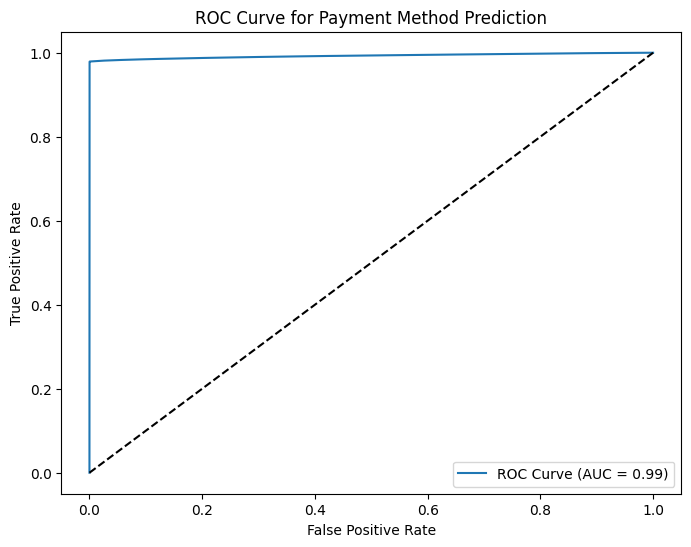

In [ ]:
# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Payment Method Prediction')
plt.legend(loc='best')
plt.show()

In [ ]:
# Calculating optimal threshold using Youden's J Statistic
j_scores = np.array(tpr) - np.array(fpr)
optimal_index = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_index]
print(f"Optimal threshold based on Youden's J statistic: {optimal_threshold:.3f}")

Optimal threshold based on Youden's J statistic: 0.430


### Applying Optimal Threshold

In [ ]:
predictions = predictions.withColumn("optimal_prediction",
                                     (col("credit_card_probability") >= optimal_threshold).cast("int"))

### Re-evaluation of the Model

In [ ]:
optimal_auc = evaluator_auc.evaluate(predictions.withColumn("rawPrediction", col("credit_card_probability")))
print(f"Model AUC using the optimal threshold = {optimal_auc:.3f}")

Model AUC using the optimal threshold = 0.993


### Visualization

In [ ]:
tp = predictions.filter((col("optimal_prediction") == 1) & (col("label") == 1)).count()
tn = predictions.filter((col("optimal_prediction") == 0) & (col("label") == 0)).count()
fp = predictions.filter((col("optimal_prediction") == 1) & (col("label") == 0)).count()
fn = predictions.filter((col("optimal_prediction") == 0) & (col("label") == 1)).count()

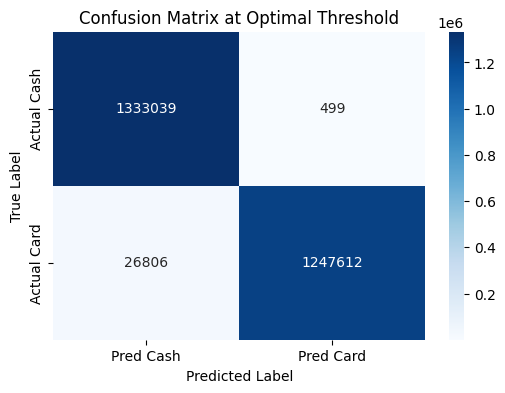

In [ ]:
confusion_matrix = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Cash", "Pred Card"], yticklabels=["Actual Cash", "Actual Card"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix at Optimal Threshold")
plt.show()

### Interpretation of Result

1. **True Positives (Pred Card | Actual Card)**:
   - **1,247,612** predictions correctly identified as "Card" payments.

   - This indicates that the model is highly effective at correctly classifying card payments.

2. **True Negatives (Pred Cash | Actual Cash)**:
   - **1,333,039** predictions correctly identified as "Cash" payments.

   - The model also performs well in identifying cash payments accurately.

3. **False Positives (Pred Card | Actual Cash)**:
   - **499** instances where the model incorrectly predicted "Card" for actual "Cash" payments.

   - This is a very low number, suggesting that the model rarely misclassifies cash payments as card payments.

4. **False Negatives (Pred Cash | Actual Card)**:
   - **26,806** instances where the model incorrectly predicted "Cash" for actual "Card" payments.

   - Although this number is higher than the false positives, it is still relatively low given the large dataset, indicating that the model generally does well at predicting card payments, though a few card transactions are misclassified as cash.

   ### Summary
   
- **High Accuracy**: The confusion matrix shows a very high true positive and true negative rate, suggesting that the model is highly accurate in distinguishing between cash and card payments.

- **Minor Misclassifications**: The low number of misclassifications (false positives and false negatives) indicates that the model is well-calibrated with a good balance between precision and recall for both classes.

It could be used in settings, such as managing payment processing resources or for targeted marketing strategies based on payment preferences.

---

## **Question 5** - *Predict the fare of a taxi trip based on borough-specific factors such as pickup and drop-off boroughs, and analyze how fares vary across different NYC boroughs*

   - **Mapping Boroughs**: Mapped PULocationID and DOLocationID to NYC boroughs using a lookup table to analyze fare variations by borough.

   - **One-Hot Encoding for Boroughs**: Converted borough information into numerical format using OneHotEncoding, enabling the model to incorporate categorical features effectively.

   - **Random Forest Regressor**: Predicted fare amount with a Random Forest Regressor using spatial and trip-specific features, assessing performance with RMSE and MAE.


### Data loading

In [ ]:
required_columns = ["PULocationID", "DOLocationID", "trip_distance", "pickup_hour",
                    "rush_hour", "fare_per_mile", "passenger_count", "fare_amount",
                    "tip_amount", "total_amount", "trip_duration"]

In [ ]:
# Loading the sampled data and selecting the required columns
sampled_data = None
for month_val in range(7, 13):  # From July to December
    sampled_file_path = f"{sampled_data_dir}yellow_tripdata_2012-{month_val:02d}_sampled.parquet"
    month_data = spark.read.parquet(sampled_file_path).select(*required_columns)
    sampled_data = month_data if sampled_data is None else sampled_data.union(month_data)


### Correlation Analysis

In [ ]:
# Converting to Pandas for correlation matrix visualization
correlation_df = sampled_data.select("trip_distance", "fare_amount", "pickup_hour", "tip_amount",
                                     "total_amount", "rush_hour", "trip_duration",
                                     "passenger_count", "fare_per_mile").toPandas()

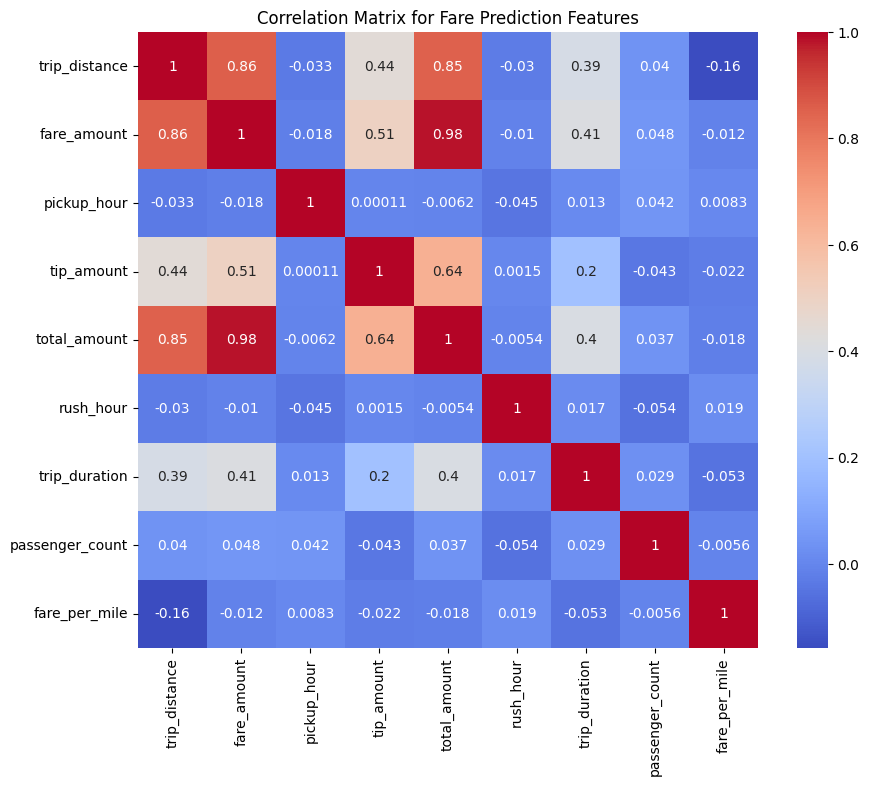

In [ ]:
# Plotting correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for Fare Prediction Features")
plt.show()

In [ ]:
# Based on the correlation analysis, we will proceed with the final selected features
final_columns = ["trip_distance", "tip_amount", "trip_duration", "fare_amount", "fare_per_mile"]

### Mapping

In [ ]:
# Mapping PULocationID and DOLocationID to Boroughs
zone_lookup = spark.read.csv(zone_lookup_path, header=True, inferSchema=True)
zone_lookup = zone_lookup.select("LocationID", "Borough").withColumnRenamed("LocationID", "PULocationID")

In [ ]:
# Joining the pickup and dropoff boroughs to the main data
sampled_data = sampled_data.join(zone_lookup.withColumnRenamed("Borough", "pickup_borough"), on="PULocationID", how="left")
sampled_data = sampled_data.join(zone_lookup.withColumnRenamed("PULocationID", "DOLocationID").withColumnRenamed("Borough", "dropoff_borough"),
                                 on="DOLocationID", how="left")

In [ ]:
# Dropping unnecessary columns
sampled_data = sampled_data.drop("PULocationID", "DOLocationID")

### One-Hot Encoding for Boroughs

In [ ]:
pickup_indexer = StringIndexer(inputCol="pickup_borough", outputCol="pickup_borough_index").fit(sampled_data)
sampled_data = pickup_indexer.transform(sampled_data)

In [ ]:
dropoff_indexer = StringIndexer(inputCol="dropoff_borough", outputCol="dropoff_borough_index").fit(sampled_data)
sampled_data = dropoff_indexer.transform(sampled_data)

In [ ]:
# Applying One-Hot Encoding
encoder = OneHotEncoder(inputCols=["pickup_borough_index", "dropoff_borough_index"],
                        outputCols=["pickup_borough_vec", "dropoff_borough_vec"])
sampled_data = encoder.fit(sampled_data).transform(sampled_data)

### Assembling Features

In [ ]:
feature_columns = ["trip_distance", "tip_amount", "trip_duration",
                    "pickup_borough_vec", "dropoff_borough_vec"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="unscaled_features")
sampled_data = assembler.transform(sampled_data)

### Feature Scaling

In [ ]:
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(sampled_data)
sampled_data = scaler_model.transform(sampled_data)

### Data Splitting

In [ ]:
train_data, test_data = sampled_data.randomSplit([0.8, 0.2], seed=42)

### Model Training

In [ ]:
rf = RandomForestRegressor(featuresCol="features", labelCol="fare_amount", numTrees=50, maxDepth=10, seed=42)
rf_model = rf.fit(train_data)

### Model Testing

In [ ]:
predictions = rf_model.transform(test_data)

### Model Evaluation

In [ ]:
evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse:.3f}")

Root Mean Squared Error (RMSE) on test data = 3.090


In [ ]:
evaluator_mae = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae:.3f}")

Mean Absolute Error (MAE) on test data = 1.168


### Analysis of Fare Distributions Across Boroughs

In [ ]:
# Converting to Pandas DataFrame for visualization
pandas_df = sampled_data.select("fare_amount", "pickup_borough", "dropoff_borough").toPandas()

#### Fare Distribution for each Pickup Borough

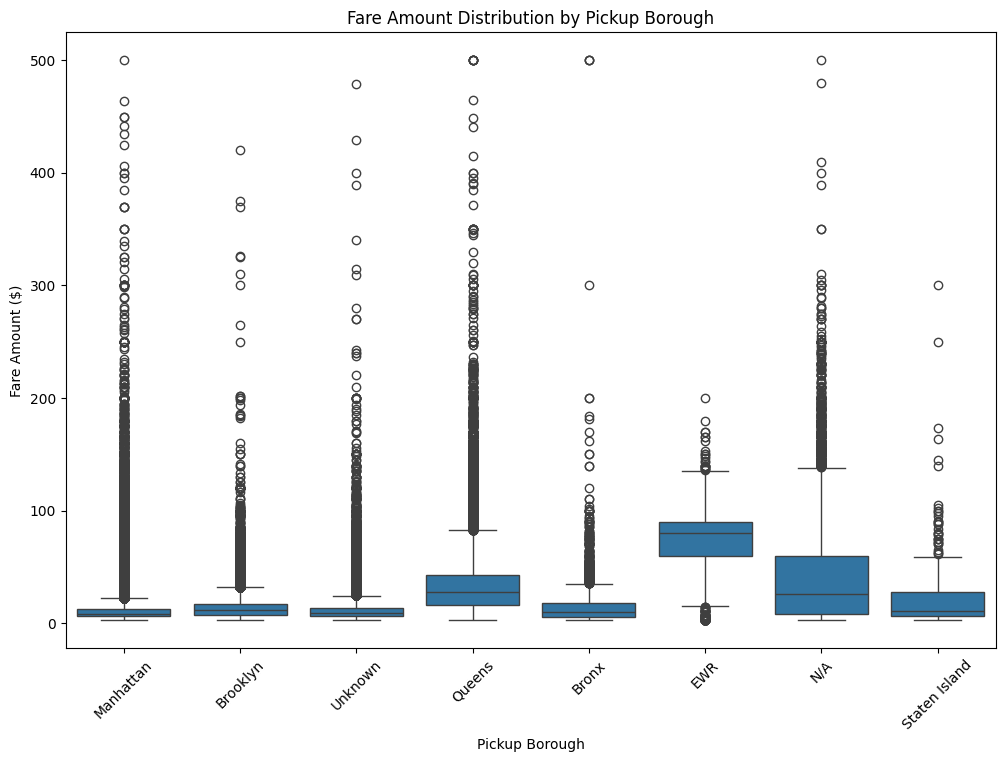

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="pickup_borough", y="fare_amount", data=pandas_df)
plt.title("Fare Amount Distribution by Pickup Borough")
plt.xlabel("Pickup Borough")
plt.ylabel("Fare Amount ($)")
plt.xticks(rotation=45)
plt.show()

#### Fare Distribution for each Dropoff Borough

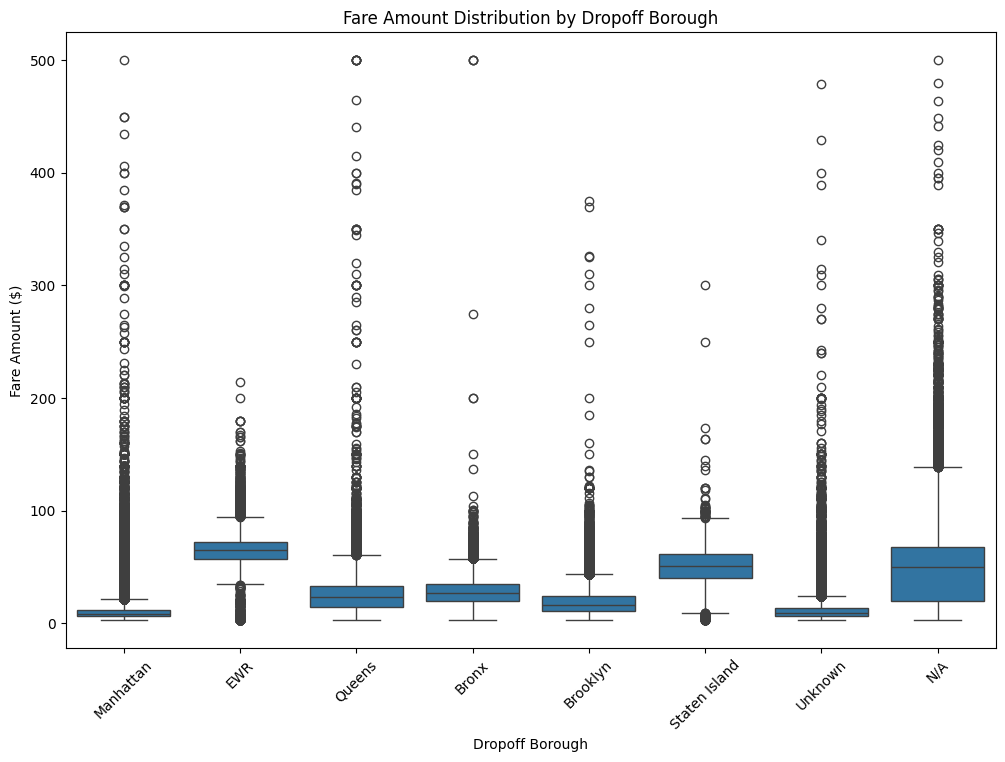

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="dropoff_borough", y="fare_amount", data=pandas_df)
plt.title("Fare Amount Distribution by Dropoff Borough")
plt.xlabel("Dropoff Borough")
plt.ylabel("Fare Amount ($)")
plt.xticks(rotation=45)
plt.show()

### Interpretation of Result

The box plots for fare amount distribution by pickup and drop-off boroughs reveal several key insights:

1. **Median Fares**:
   - **Pickup Borough**: Median fares vary significantly by pickup borough. Manhattan, Brooklyn, Bronx, and Staten Island generally have lower median fares, while EWR (Newark Airport) and "N/A" (likely  unidentified locations) show higher median fares.

   - **Drop-off Borough**: Similarly, drop-off locations like EWR and "N/A" have notably higher median fares compared to other boroughs, suggesting that trips to these areas tend to be longer or more expensive.

2. **Fare Range**:
   - **Pickup**: Trips originating from EWR and "N/A" locations show a wider fare range, often with values exceeding 200 Dollars. In contrast, Manhattan and Brooklyn have a narrower fare range, with most fares under 100 Dollars.

   - **Drop-off**: Similar trends are observed, with drop-offs at EWR and "N/A" locations showing higher fare variability. This could reflect longer distances or additional charges associated with these areas.

3. **Outliers**:
   - Both plots contain outliers with fares well over 200 Dollars, even reaching up to 500 Dollars. These likely represent exceptionally long trips, possibly to other states or during peak demand periods.

4. **Borough-Specific Insights**:
   - **EWR (Newark Airport)**: Both pickup and drop-off fares at Newark Airport are higher on average, which aligns with the known surcharge for airport trips and the typically longer distances involved.

   - **"N/A" and Unknown**: These categories, especially as drop-off points, indicate a high fare range, suggesting that trips with these designations might involve travel outside the primary NYC zones, incurring higher costs.


---

## **Question 6** - *Predict the tip amount given by passengers based on trip characteristics*

   - **Features**: Used features like trip distance, fare amount, tip-to-fare ratio, and trip duration to predict the tip amount.

   - **Evaluation and Visualization**: RMSE and MAE were calculated to evaluate performance, and a scatter plot of Actual vs. Predicted tips was created to show prediction accuracy and variability, indicating the model's general ability to predict tipping trends.


### Data Loading

In [ ]:
# Defin required columns for predicting tip amount
required_columns = [
    "trip_distance", "fare_amount", "tip_to_fare_ratio",
    "trip_duration", "tip_amount"
]


In [ ]:
# Loading the sampled data and selecting the required columns
sampled_data = None
for month_val in range(7, 13):  # From July to December
    sampled_file_path = f"{sampled_data_dir}yellow_tripdata_2012-{month_val:02d}_sampled.parquet"
    month_data = spark.read.parquet(sampled_file_path).select(*required_columns)
    sampled_data = month_data if sampled_data is None else sampled_data.union(month_data)

### Data Filtering

In [ ]:
# Filtering out rows with missing or zero values in tip_amount and fare_amount
sampled_data = sampled_data.filter((col("tip_amount") > 0) & (col("fare_amount") > 0))

### Correlation Matrix

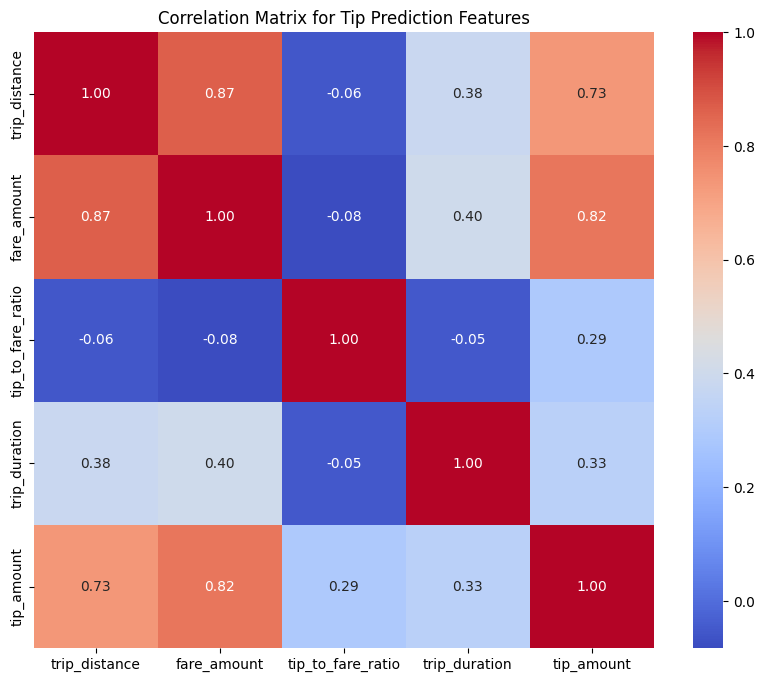

In [ ]:
# Converting Spark DataFrame to Pandas for correlation visualization
pandas_df = sampled_data.select("trip_distance", "fare_amount", "tip_to_fare_ratio", "trip_duration", "tip_amount").toPandas()
plt.figure(figsize=(10, 8))
sns.heatmap(pandas_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Tip Prediction Features")
plt.show()

### Assembling Features

In [ ]:
# Assembling features for regression
feature_columns = ["trip_distance", "fare_amount", "tip_to_fare_ratio", "trip_duration"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="unscaled_features")
sampled_data = assembler.transform(sampled_data)

### Feature Scaling

In [ ]:
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(sampled_data)
sampled_data = scaler_model.transform(sampled_data)

### Data Splitting

In [ ]:
# Splitting data into training and test sets
train_data, test_data = sampled_data.randomSplit([0.8, 0.2], seed=42)

### Model Training

In [ ]:
# Initializing and training the Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="tip_amount", numTrees=50, maxDepth=10, seed=42)
rf_model = rf.fit(train_data)

### Model Testing

In [ ]:
# Making predictions on the test set
predictions = rf_model.transform(test_data)

### Model Evaluation

In [ ]:
# Evaluating Model Performance using RMSE and MAE
evaluator_rmse = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse:.3f}")

Root Mean Squared Error (RMSE) on test data = 0.555


In [ ]:
evaluator_mae = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae:.3f}")

Mean Absolute Error (MAE) on test data = 0.128


### Visualization

In [ ]:
# Converting to Pandas DataFrame for visualization
pandas_df_predictions = predictions.select("tip_amount", "prediction").toPandas()

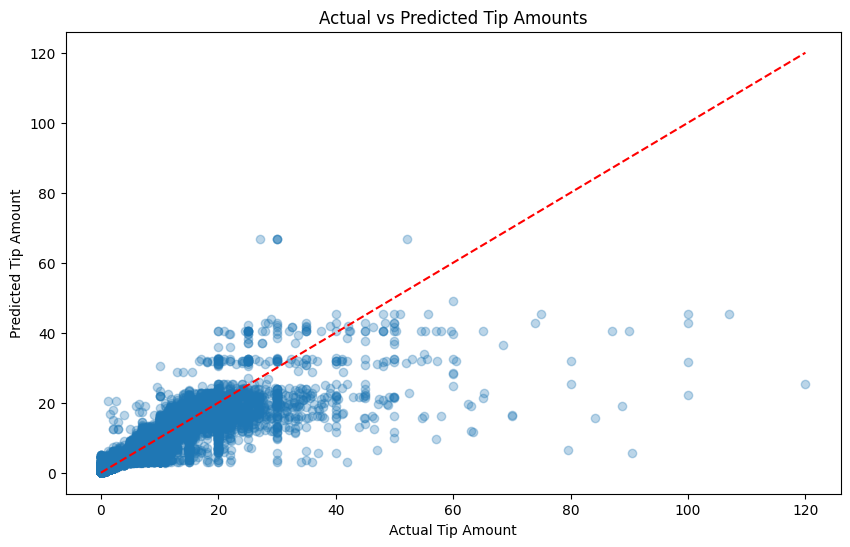

In [ ]:
# Plotting Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df_predictions["tip_amount"], pandas_df_predictions["prediction"], alpha=0.3)
plt.plot([0, max(pandas_df_predictions["tip_amount"])], [0, max(pandas_df_predictions["tip_amount"])], 'r--')  # Line y=x for reference purpose
plt.xlabel("Actual Tip Amount")
plt.ylabel("Predicted Tip Amount")
plt.title("Actual vs Predicted Tip Amounts")
plt.show()

### Interpretation of Result

- **Root Mean Squared Error (RMSE)**: An RMSE of 0.555 indicates that, on average, the predicted tip amount deviates from the actual tip amount by around 0.555 units.

- **Mean Absolute Error (MAE)**: An MAE of 0.128 is relatively low, meaning the absolute deviation between predicted and actual tips is, on average, quite small. This indicates that the model is generally making precise predictions, with small errors.

- **Correlation with Actual Tips**: The scatter plot shows predicted vs. actual tip amounts, with a red diagonal line indicating perfect predictions. Points close to this line represent accurate predictions, while points farther away represent larger prediction errors.

- **Outliers and Variability**: There is some spread in the points above the 50 unit mark on both axes, which suggests that the model might struggle slightly with very high tip amounts. This could be due to fewer data points for high tips, causing the model to be less accurate in this range.

- **Positive Relationship**: Overall, the plot indicates a generally positive relationship between predicted and actual tips, showing that the model can capture the trend of tipping amounts well.

---

## **Question 7** - *Predict whether a trip will result in a high or low fare based on early trip data*

- **Correlation Analysis**: Analyzed correlations between `trip_distance`, `fare_amount`, `tip_amount`, and `trip_duration` to confirm predictive relationships for fare classification.

- **Random Forest Classifier**: Trained a Random Forest Classifier to classify trips as high or low fare based on early trip data, achieving high AUC, accuracy, precision, and recall.

- **Confusion Matrix**: Visualized classification results with a confusion matrix, showing low false positives and false negatives, indicating high precision and recall.



### Data Loading

In [ ]:
# Defining the required columns for the analysis
required_columns = ["trip_distance", "fare_amount",
                    "tip_amount", "trip_duration", "high_fare"]

In [ ]:
# Loading the sampled data and selecting the required columns
sampled_data = None
for month_val in range(7, 13):  # From July to December
    sampled_file_path = f"{sampled_data_dir}yellow_tripdata_2012-{month_val:02d}_sampled.parquet"
    month_data = spark.read.parquet(sampled_file_path).select(*required_columns)
    sampled_data = month_data if sampled_data is None else sampled_data.union(month_data)

### Correlation Analysis

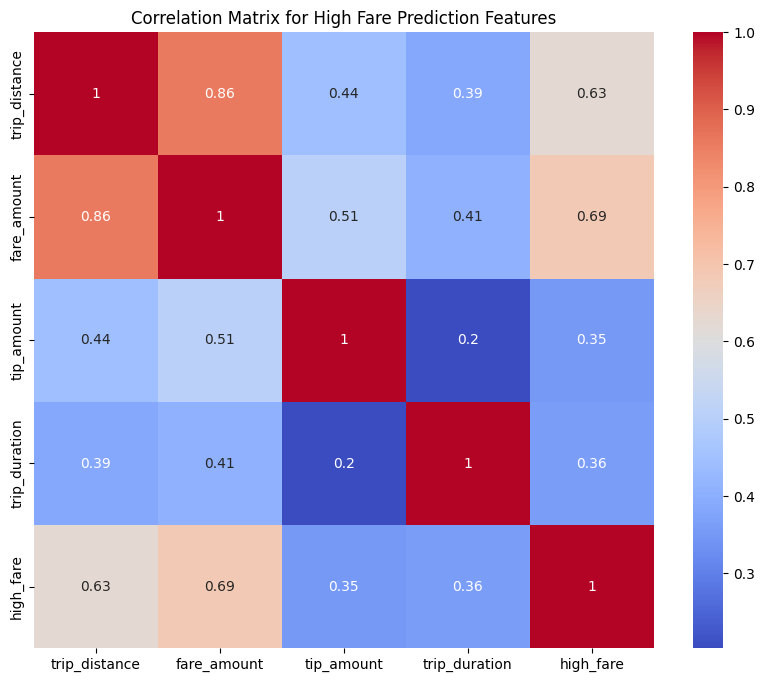

In [ ]:
# Converting Spark DataFrame to Pandas for correlation visualization
pandas_df = sampled_data.select(*required_columns).toPandas()
plt.figure(figsize=(10, 8))
sns.heatmap(pandas_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for High Fare Prediction Features")
plt.show()

### Feature Definition

In [ ]:
feature_columns = ["trip_distance", "fare_amount", "tip_amount", "trip_duration"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="unscaled_features")
sampled_data = assembler.transform(sampled_data)

### Feature Scaling

In [ ]:
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(sampled_data)
sampled_data = scaler_model.transform(sampled_data)

### Data Splitting

In [ ]:
# Splitting data into training and test sets
train_data, test_data = sampled_data.randomSplit([0.8, 0.2], seed=42)


### Model Training

In [ ]:
rf = RandomForestClassifier(featuresCol="features", labelCol="high_fare", numTrees=50, maxDepth=10, seed=42)
rf_model = rf.fit(train_data)

### Model Testing

In [ ]:
# Making predictions on the test set
predictions = rf_model.transform(test_data)

### Model Evaluation

In [ ]:
# Evaluating Model Performance using AUC, Accuracy, Precision, and Recall
binary_evaluator = BinaryClassificationEvaluator(labelCol="high_fare", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)
print(f"AUC on test data = {auc:.3f}")

AUC on test data = 1.000


In [ ]:
# Calculating Accuracy, Precision, and Recall
tp = predictions.filter((col("prediction") == 1) & (col("high_fare") == 1)).count()
tn = predictions.filter((col("prediction") == 0) & (col("high_fare") == 0)).count()
fp = predictions.filter((col("prediction") == 1) & (col("high_fare") == 0)).count()
fn = predictions.filter((col("prediction") == 0) & (col("high_fare") == 1)).count()

In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

In [ ]:
print(f"Accuracy on test data = {accuracy:.3f}")
print(f"Precision on test data = {precision:.3f}")
print(f"Recall on test data = {recall:.3f}")

Accuracy on test data = 1.000
Precision on test data = 1.000
Recall on test data = 0.999


### Optimal Threshold Calculation for confirmation



In [ ]:
# Optimal Threshold Calculation using ROC Curve and Youden's J Statistic
def extract_high_fare_probability(probability):
    return float(probability[1])  # Probability for class 1 (High Fare)
extract_high_fare_probability_udf = udf(extract_high_fare_probability, DoubleType())
predictions = predictions.withColumn("high_fare_probability", extract_high_fare_probability_udf(col("probability")))

In [ ]:
# Collecting true labels and predicted probabilities
preds_and_labels = predictions.select("high_fare_probability", "high_fare").collect()
probs = np.array([row["high_fare_probability"] for row in preds_and_labels])
labels = np.array([row["high_fare"] for row in preds_and_labels])

In [ ]:
# Calculating ROC Curve
fpr, tpr, thresholds = [], [], []
sorted_indices = np.argsort(probs)[::-1]
probs, labels = probs[sorted_indices], labels[sorted_indices]

In [ ]:
for threshold in np.unique(probs):
    tp = np.sum((probs >= threshold) & (labels == 1))
    fp = np.sum((probs >= threshold) & (labels == 0))
    fn = np.sum((probs < threshold) & (labels == 1))
    tn = np.sum((probs < threshold) & (labels == 0))
    tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
    thresholds.append(threshold)

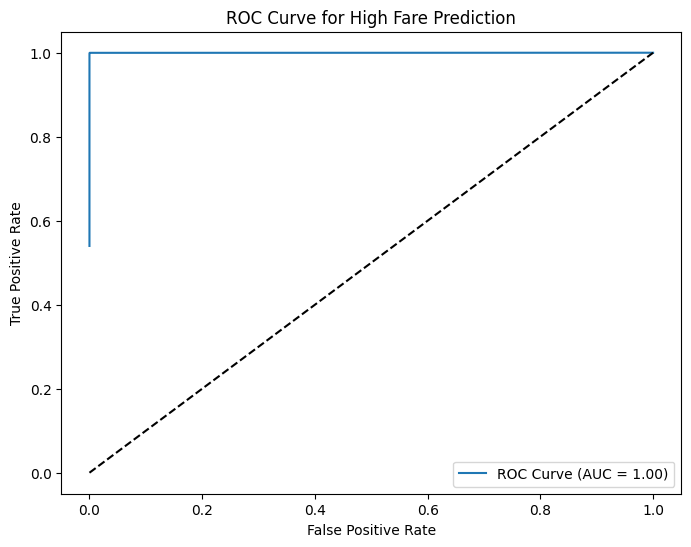

In [ ]:
# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for High Fare Prediction')
plt.legend(loc='best')
plt.show()

In [ ]:
# Calculating optimal threshold using Youden's J Statistic
j_scores = np.array(tpr) - np.array(fpr)
optimal_index = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_index]
print(f"Optimal threshold based on Youden's J statistic: {optimal_threshold:.3f}")

Optimal threshold based on Youden's J statistic: 0.353


### Applying Optimal Threshold

In [ ]:
predictions = predictions.withColumn("optimal_prediction",
                                     (col("high_fare_probability") >= optimal_threshold).cast("int"))

### Re-evaluation of the Model

In [ ]:
# Re-evaluating Model with Optimal Threshold
optimal_auc = binary_evaluator.evaluate(predictions.withColumn("rawPrediction", col("high_fare_probability")))
print(f"Model AUC using the optimal threshold = {optimal_auc:.3f}")

Model AUC using the optimal threshold = 1.000


### Visualization

In [ ]:
# Visualizing Confusion Matrix at Optimal Threshold
tp = predictions.filter((col("optimal_prediction") == 1) & (col("high_fare") == 1)).count()
tn = predictions.filter((col("optimal_prediction") == 0) & (col("high_fare") == 0)).count()
fp = predictions.filter((col("optimal_prediction") == 1) & (col("high_fare") == 0)).count()
fn = predictions.filter((col("optimal_prediction") == 0) & (col("high_fare") == 1)).count()

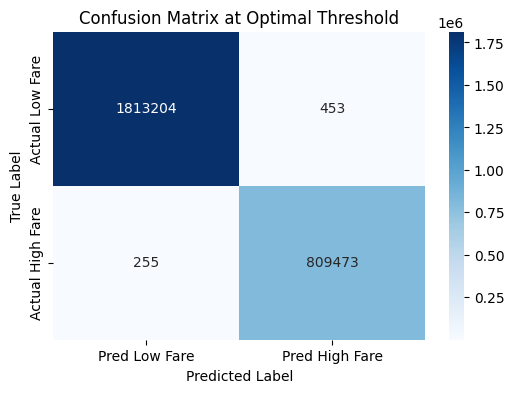

In [ ]:
confusion_matrix = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Low Fare", "Pred High Fare"], yticklabels=["Actual Low Fare", "Actual High Fare"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix at Optimal Threshold")
plt.show()

### Interpretation of Result
- **Precision**: A precision of 1.000 means that every trip the model predicted as "high fare" was indeed a high-fare trip. This is critical in applications where you want to minimize false positives (i.e., trips incorrectly classified as high fare).

- **Recall**: The recall is 0.999, meaning the model identifies nearly all actual high-fare trips as high fare. The high recall implies that the model has very few false negatives, so it seldom misses predicting high-fare trips correctly.

- **True Positives (TP)**: 809,473 - Trips that were actually high fare and correctly predicted as high fare.

- **True Negatives (TN)**: 1,813,204 - Trips that were actually low fare and correctly predicted as low fare.

- **False Positives (FP)**: 453 - Trips that were actually low fare but incorrectly predicted as high fare.

- **False Negatives (FN)**: 255 - Trips that were actually high fare but incorrectly predicted as low fare.

The low values for FP and FN reinforce the model’s high precision and recall.

---
# **References**

1. [TLC Website](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

2. [Yellow Trips Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

3. [Taxi Zone Lookup Table](https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv)

---